Number of times null hypothesis is rejected: 80 out of 500 simulations
Type 1 Error: 0.16
Bias for Coefficient of Treatment : -0.03737539515364349
MSE for Coefficient of Treatment : 0.0013303963711374272
RMSE for Coefficient of Treatment : 0.03647459898528601
Average Standard Error: 0.026229229146368844
Standard Error of the beta_1 distribution: 0.030144112113296245
The confidence interval is (-0.029618498211990855, {0.08854642127213042})


c:\Users\sneha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


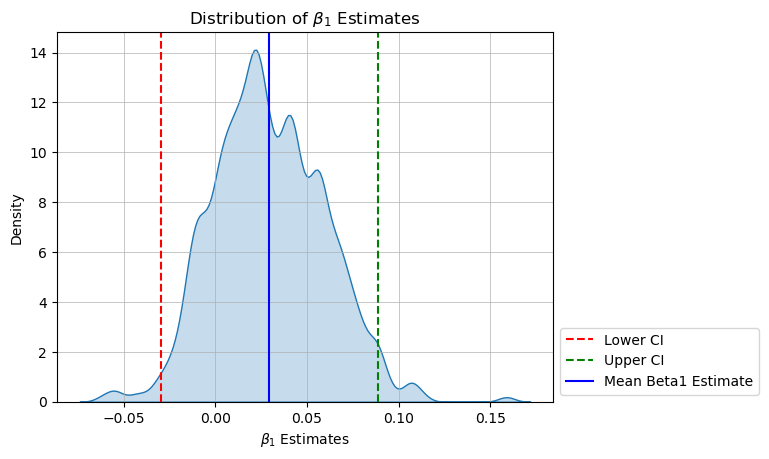

In [7]:
file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz'

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from cps_data_prep_power import cps_data

alpha = 0.05  # Significance level
num_simulations = 500
num_of_states = 6
np.random.seed(42)

reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0.05   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []



df = cps_data(file_path = file_path)

for _ in range(num_simulations):

    data = df.copy()

    unique_statefips = data['STATEFIP'].unique()
    selected_statefips = np.random.choice(unique_statefips, size=num_of_states, replace=False)

   # Filter the DataFrame to only include rows with the selected STATEFIPs
    data = data[data['STATEFIP'].isin(selected_statefips)]
    
    states = data['STATEFIP'].unique()
    
    # Randomly selecting  half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assigning treatment year to each treatment state, staggered between 1985 and 1995

    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame

    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)

    data['outcome'] = data.apply(lambda x: x['INCWAGE']*(1.05) if x['TREATMENT'] == 1 else x['INCWAGE'], axis=1)

    data['outcome'] = np.log(data['outcome'])

    # Data aggregation is being done after the 2% effect has been introduced

    X = data[['High School', "Master's Degree", 'AGE']]
    y = data['outcome']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    y_pred = model.predict(X)   # Obtain predicted values from the fitted model

    residuals = y - y_pred

    data['Residuals'] = residuals

    cps_agg = data.groupby(['STATEFIP', 'YEAR'])[['Residuals', 'TREATMENT']].mean().reset_index()

    dummy_df_state = pd.get_dummies(cps_agg['STATEFIP'], prefix='STATEFIP', drop_first=True).astype(int)  # One-hot encode STATEFIP and YEAR
    dummy_df_year = pd.get_dummies(cps_agg['YEAR'], prefix='YEAR', drop_first=True).astype(int)

    
    cps_agg = pd.concat([cps_agg, dummy_df_state, dummy_df_year], axis=1)

    data = cps_agg.copy()
    
    columns_to_exclude = ['STATEFIP', 'YEAR', 'Residuals', 'TREATMENT']

    X_columns =[col for col in data.columns if col not in columns_to_exclude]

    X = data[X_columns]
    X = sm.add_constant(X)
    Y = data['Residuals'] 
    
    model = sm.OLS(Y, X).fit()

    y_pred = model.predict(X)

    residuals = Y - y_pred

    data['Residuals_2'] = residuals

    a = state_to_treatment_year.keys()

    filtered_df = data[data['STATEFIP'].isin(a)]
    

    # Separating pre-treatment and post-treatment data

    pre_treatment_df = filtered_df[filtered_df['TREATMENT'] == 0]
    post_treatment_df = filtered_df[filtered_df['TREATMENT'] == 1]

    # Calculating the average residuals for pre-treatment and post-treatment periods

    avg_residuals_pre_treatment = pre_treatment_df.groupby('STATEFIP')['Residuals_2'].mean().reset_index()
    avg_residuals_post_treatment = post_treatment_df.groupby('STATEFIP')['Residuals_2'].mean().reset_index()

    # Adding a 'Treatment' column to indicate the treatment status for each period

    avg_residuals_pre_treatment['Treatment'] = 0
    avg_residuals_post_treatment['Treatment'] = 1

    # Combining the two DataFrames into a new DataFrame

    two_period_panel_df = pd.concat([avg_residuals_pre_treatment, avg_residuals_post_treatment], ignore_index=True)
    
    # Defining the dependent and independent variables
    
    y = two_period_panel_df['Residuals_2']
    X = two_period_panel_df[['Treatment']]
    
    # Adding a constant term (intercept) to the independent variables

    X = sm.add_constant(X)
    

    model = sm.OLS(y, X).fit()   # Fitting the regression model
    
    standard_error = model.bse['Treatment']  # Extracting the standard error of the 'Treatment' coefficient
    standard_error_values.append(standard_error)

    
    beta1_estimates.append(model.params['Treatment'])

    bias = model.params['Treatment'] - true_beta1_value
    bias_values.append(bias)

    squared_error = (model.params['Treatment'] - true_beta1_value) ** 2
    squared_error_values.append(squared_error)

    
    if model.pvalues['Treatment'] < alpha:  # checking if null hypothesis for beta1 is rejected
        reject_count += 1

type1_error = reject_count/ num_simulations
bias = np.mean(bias)
mse = np.mean(squared_error_values)
rmse = np.sqrt(mse)
average_standard_error = np.mean(standard_error_values)

# Calculating the standard error of the distribution of beta

std_error_beta_distribution = np.std(beta1_estimates)

# Calculating the confidence interval
confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.kdeplot(beta1_estimates, bw_adjust=0.5, fill=True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()



    



In [8]:
data['STATEFIP'].unique()

array([ 9, 12, 15, 30, 48, 56], dtype=int64)